# CSCI-537 Final Project
# CAPTCHA Solver
### Fall 2021
### Hayden Sather, Jake Pinkston

#### Dependencies
pip3 install idx2numpy  
pip3 install python-mnist

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import global_params as gp
import helper_funcs as hf

In [2]:
model = hf.get_model(retrain=False)

2021-11-16 23:00:32.513846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-16 23:00:32.517746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2021-11-16 23:00:32.517758: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-16 23:00:32.517993: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

909/909 [==============================] - 5s 5ms/step - loss: 0.3662 - accuracy: 0.8678
Accuracy on EMNIST test data: 0.867824912071228


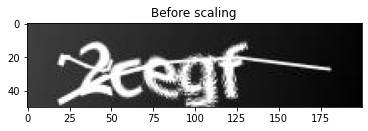

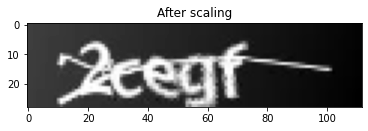


Confidence: 0.43285573
Predicted value: b


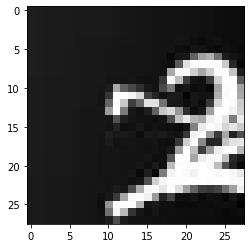


Confidence: 0.72495884
Predicted value: 8


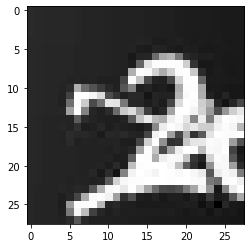


Confidence: 0.95915383
Predicted value: 8


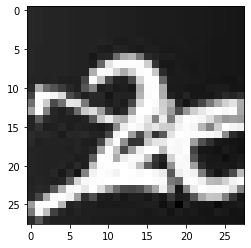


Confidence: 0.98975694
Predicted value: 8


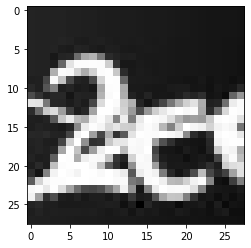


Confidence: 0.7313612
Predicted value: 8


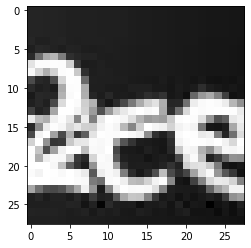


Confidence: 0.7023814
Predicted value: 8


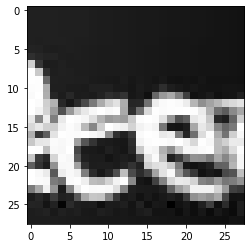


Confidence: 0.6003879
Predicted value: 8


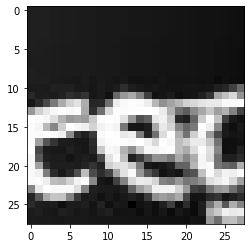


Confidence: 0.874919
Predicted value: A


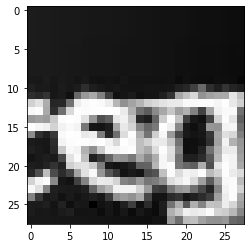


Confidence: 0.48425332
Predicted value: 8


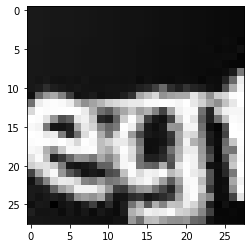


Confidence: 0.7848154
Predicted value: A


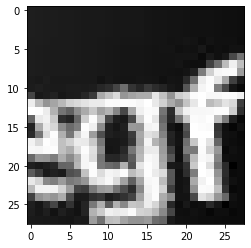


Confidence: 0.9164274
Predicted value: 8


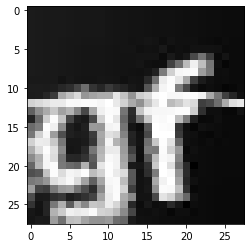


Confidence: 0.27093902
Predicted value: 8


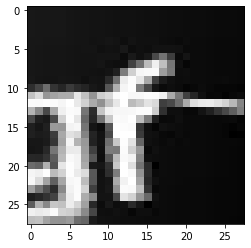


Confidence: 0.6973049
Predicted value: 8


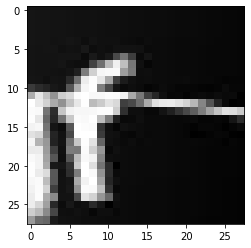


Confidence: 0.35054275
Predicted value: T


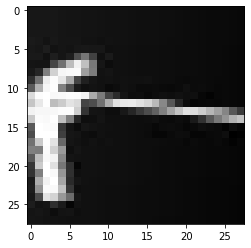


Confidence: 0.7443024
Predicted value: T


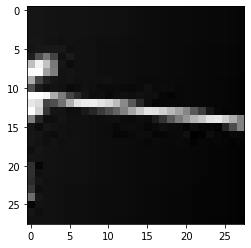


Confidence: 0.88521576
Predicted value: T


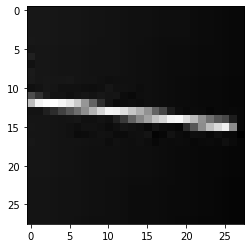


Confidence: 0.7670022
Predicted value: T


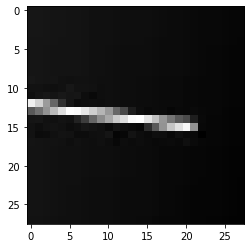

In [3]:
# Hard data. Bad performance on this data for now.

img = cv2.imread("hard_data/2cegf.png")

# Turn greyscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Invert color of image
img = 255 - img

# Scale to 0-1
img = img.astype("float32") / 255

# Morphology. Doesn't help performance as of now
# kernel = np.ones((3, 3),np.uint8)
# img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("Before scaling")
plt.show()

# Make threshold for darkest color. Doesn't help performance as of now
# img[img < 0.3] = 0

# Scale image
ratio = img.shape[1] / img.shape[0]
width = round(gp.IMG_SIZE * ratio)
dim = (width, gp.IMG_SIZE)
img = cv2.resize(img, dim)

plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("After scaling")
plt.show()

step_size = 5
for left_boundary in range(0, img.shape[1] - gp.IMG_SIZE, step_size):
    right_boundary = left_boundary + gp.IMG_SIZE
    img_slice = img[:, left_boundary : right_boundary]


    img_slice_fixed = np.expand_dims(img_slice, -1)
    img_slice_fixed = np.expand_dims(img_slice_fixed, 0)
    
    prediction = model.predict(img_slice_fixed)
    print("\nConfidence:", np.max(prediction))
    decoded_value = hf.decode_prediction(prediction)
    print("Predicted value:", decoded_value)

    plt.imshow(img_slice, cmap=plt.get_cmap('gray'))
    plt.show()

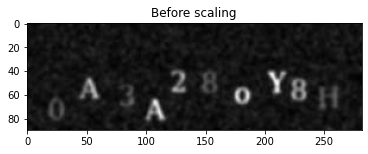

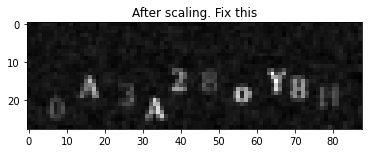


Confidence: 0.36902538
Predicted value: 1


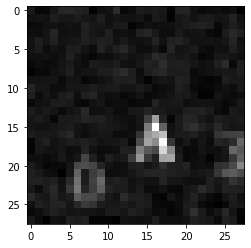


Confidence: 0.4409158
Predicted value: I


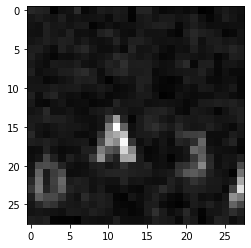


Confidence: 0.42746434
Predicted value: 1


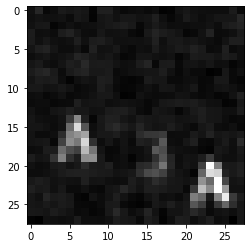


Confidence: 0.48119378
Predicted value: 1


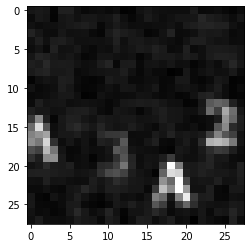


Confidence: 0.36461824
Predicted value: 1


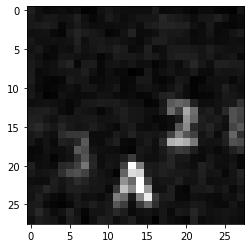


Confidence: 0.3476946
Predicted value: 1


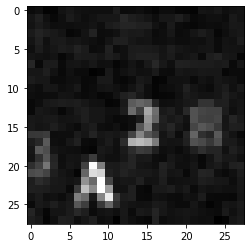


Confidence: 0.41939512
Predicted value: 1


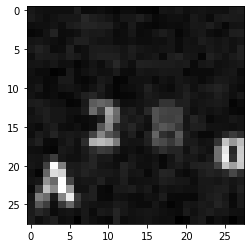


Confidence: 0.5263039
Predicted value: 1


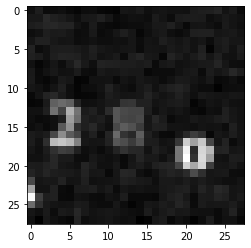


Confidence: 0.5017818
Predicted value: 1


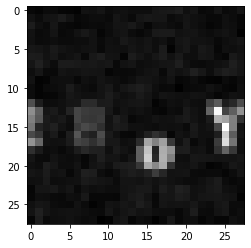


Confidence: 0.4697635
Predicted value: I


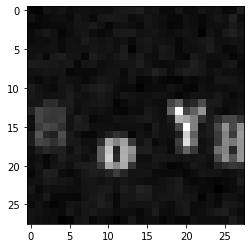


Confidence: 0.39683035
Predicted value: I


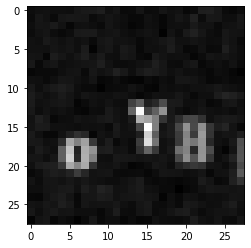


Confidence: 0.30018386
Predicted value: I


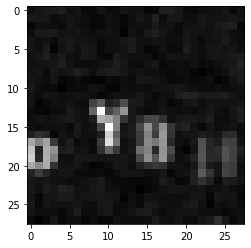

In [4]:
# Easy data

img = cv2.imread("easy_data/0A3A28oY8H.jpg")

# Turn greyscale
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Invert color of image
img = 255 - img

# Scale to 0-1
img = img.astype("float32") / 255

# Morphology. Doesn't help performance as of now
# kernel = np.ones((3, 3),np.uint8)
# img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)

plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("Before scaling")
plt.show()

# Make threshold for darkest color. Doesn't help performance as of now
# img[img < 0.3] = 0

# TODO: Jake, find a way to step through this image with a moving filter at an appropriate size and step size with a 28x28 filter so that all the letters
# in the image are seen by the filter. Then apply the CNN to it (Code provided) and see what it outputs. This is very similar to what I did above but
# these new images require movement vertically, rather than just horizontally, which is what it does now

# Scale image. NOTE: You will likely find you don't need to scale the image until after you find the correct crops and step size for the letters.
# It is obviously way too lowly scaled now. I am just leaving this code here because it breaks down below if not because the size is wrong
ratio = img.shape[1] / img.shape[0]
height = 28  # This remains the same
width = round(height * ratio)
dim = (width, height)
img = cv2.resize(img, dim)

plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.title("After scaling. Fix this")
plt.show()

step_size = 5
width = 28  # This remains the same
for left_boundary in range(0, img.shape[1] - width, step_size):
    right_boundary = left_boundary + width
    img_slice = img[:, left_boundary : right_boundary]

    img_slice_fixed = np.expand_dims(img_slice, -1)
    img_slice_fixed = np.expand_dims(img_slice_fixed, 0)
    
    prediction = model.predict(img_slice_fixed)
    print("\nConfidence:", np.max(prediction))
    decoded_value = hf.decode_prediction(prediction)
    print("Predicted value:", decoded_value)

    plt.imshow(img_slice, cmap=plt.get_cmap('gray'))
    plt.show()